### GRPO Fine-Tuning with MLX LM

In this notebook, we'll walk through how to fine-tune an LLM with **Group Relative Policy Optimization (GRPO)** using MLX LM. GRPO is a Reinforcement Learning algorithm similar to PPO. We'll use the [HellaSwag](https://rowanzellers.com/hellaswag/) dataset for common sense reasoning as an example. An outline:

1. Download the dataset and prepare it for the GRPO loop.
2. Setup and run GRPO training. We will implement the full RL loop, including rollout, reward calculation, and optimization with the PPO-clip objective.
3. Evaluate the final accuracy on the test set.
4. Fuse the resulting adapters into the base model.
5. Discuss tips for debugging accuracy and efficiency.

Note: This notebook currently does not have an implementation for the reward function. Instead, it has a dummy reward logic:

```python
reward = 1.0 if batch_answers[i] in response else 0.0
```

I will add a reward function to this notebook later on and inform again when done, but please feel free to file a pull request if you would like to contribute in anyway.

### Install dependencies

In [1]:
!pip install mlx-lm
!pip install matplotlib

### Preprocess Data
We'll start by downloading an already pre-processed version of the HellaSwag dataset from [LLM-Adapters](https://github.com/AGI-Edgerunners/LLM-Adapters).

In [1]:
import json
import numpy as np
from pathlib import Path
from urllib import request

save_dir = "/tmp/hellaswag"

def download_and_save(save_dir):
    base_url = "https://raw.githubusercontent.com/AGI-Edgerunners/LLM-Adapters/main/dataset/hellaswag/"
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    for name in ["train.json", "test.json"]:
        out_file = save_dir / name
        if not out_file.exists():
            request.urlretrieve(base_url + name, out_file)

def load_json(dataset):
    download_and_save(save_dir)
    with open(f"{save_dir}/{dataset}.json", "r") as fid:
        return json.load(fid)

train_set, test_set = load_json("train"), load_json("test")
print(f"HellaSwag stats: {len(train_set)} training examples and {len(test_set)} test examples.")
print("An example:\n")
print(json.dumps(train_set[0], indent=4))

HellaSwag stats: 39905 training examples and 10042 test examples.
An example:

{
    "instruction": "Please choose the correct ending to complete the given sentence: Removing ice from car: Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then\n\nEnding1: , the man adds wax to the windshield and cuts it. Ending2: , a person board a ski lift, while two men supporting the head of the person wearing winter clothes snow as the we girls sled. Ending3: , the man puts on a christmas coat, knitted with netting. Ending4: , the man continues removing the snow on his car.\n\nAnswer format: ending1/ending2/ending3/ending4",
    "input": "",
    "output": "the correct answer is ending4",
    "answer": "ending4"
}


Next, let's split the training set into a training and a validation set. We'll pull out a randomly chosen 10% for validation.

In [2]:
# Seed for reproducibility
np.random.seed(43)
perm = np.random.permutation(len(train_set))
valid_size = int(0.1 * len(train_set))
valid_set = [train_set[i] for i in perm[:valid_size]]
train_set = [train_set[i] for i in perm[valid_size:]]

### Fine-Tune

For fine-tuning, we'll use Microsoft's [Phi-3 mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct). At 3.8 billion parameters, Phi-3 mini is a high-quality model that is also fast to fine-tune on most Apple silicon machines. Also, it has a [permissive MIT License](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct/blob/main/LICENSE).

First, import all the packages and functions we need.

In [3]:
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from mlx.utils import tree_flatten, tree_unflatten, tree_map
from mlx_lm import load, generate
from mlx_lm.tuner.lora import LoRALinear
from mlx_lm.tuner import linear_to_lora_layers
from mlx_lm.sample_utils import make_sampler
import tqdm
import os
import time
import copy
os.environ["TOKENIZERS_PARALLELISM"] = "true"

Next, setup the LoRA parameters.

In [4]:
# Make a directory to save the adapter config and weights
adapter_path = Path("adaptersGRPO")
adapter_path.mkdir(parents=True, exist_ok=True)

lora_config = {
 "num_layers": 8,
 "lora_parameters": {
    "rank": 8,
    "scale": 10.0, # This can be tuned
    "dropout": 0.0,
}}

# Save the LoRA config to the adapter path
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)

Next, load the models. For GRPO, we need three models:
- `model` (π_θ): The model we are training with LoRA adapters.
- `model_old` (π_θold): A copy of `model` used for generating rollouts. Its weights are periodically synchronized with `model`.
- `model_ref` (π_ref): The original pretrained model, used as a reference for the KL-divergence penalty.

In [5]:
model_path = "mlx-community/Phi-3-mini-4k-instruct-4bit"

# Load the main model and tokenizer
model, tokenizer = load(model_path);



Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
# Load the reference model
model_ref, _ = load(model_path);
model_ref.freeze();

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

After loading the main model, freeze its base parameters and convert the specified linear layers to LoRA layers. The LoRA adapters will be the only trainable parameters.

In [9]:
# Freeze the base model
print("Freezing base model...")
model.freeze()
print("Base model frozen.")
# Convert linear layers to lora layers
linear_to_lora_layers(model, lora_config["num_layers"], lora_config["lora_parameters"])
print("Converted linear layers to LoRA layers.")
# Create the old model for rollouts
model_old, _ = load(model_path)
print("Old model created.")
linear_to_lora_layers(model_old, lora_config["num_layers"], lora_config["lora_parameters"])
print("Converted old model linear layers to LoRA layers.")
model_old.update(model.parameters()) # Sync weights
print("Old model weights synced.")
model_old.freeze()
print("Old model frozen.")

num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params:,}")

Freezing base model...
Base model frozen.
Converted linear layers to LoRA layers.


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Old model created.
Converted old model linear layers to LoRA layers.
Old model weights synced.
Old model frozen.
Number of trainable parameters: 786,432


## GRPO MODIFICATION ##
### Define the GRPO loss and training loop

Here we define the core components for GRPO. This includes:
1. A helper function to calculate the log probabilities of a sequence.
2. The GRPO loss function, which computes the PPO-clip objective and KL penalty.
3. The main training loop that orchestrates the RL process.

In [10]:
from mlx import nn

def calculate_log_probs(model, sequences, a_toks):
    """Calculates the log probabilities of the generated answer tokens."""
    # Pass the full sequence (prompt + answer) to the model
    logits = model(sequences)

    # Convert to log probabilities
    log_probs_full = nn.log_softmax(logits, axis=-1)

    ## Find the actual positions where answer tokens should be extracted
    # This assumes a_toks contains the actual token IDs that were generated
    batch_size, seq_len = sequences.shape
    _, ans_len = a_toks.shape

    # Calculate the starting position for answer tokens (assuming they're at the end)
    start_pos = seq_len - ans_len

    # Extract log probabilities for the answer portion of the sequence
    answer_log_probs = log_probs_full[:, start_pos:start_pos+ans_len, :]

    # Create indices for gathering - ensure proper shape alignment
    indices = a_toks[:, :, None]

    # Extract log probabilities for the actual answer tokens
    selected_log_probs = mx.take_along_axis(answer_log_probs, indices, axis=-1).squeeze(-1)

    # Sum log probabilities across the answer sequence
    return mx.sum(selected_log_probs, axis=-1)

def grpo_loss_fn(model, model_ref, sequences, a_toks, advantages, old_log_probs, beta, epsilon):
    """The GRPO loss function."""
    # Get log probs from the trainable model (π_θ)
    log_probs = calculate_log_probs(model, sequences, a_toks)

    # Get log probs from the reference model (π_ref) for KL penalty
    log_probs_ref = calculate_log_probs(model_ref, sequences, a_toks)

    # PPO-clip objective
    ratio = mx.exp(log_probs - old_log_probs)
    clipped_ratio = mx.clip(ratio, 1.0 - epsilon, 1.0 + epsilon)
    policy_reward = mx.minimum(ratio * advantages, clipped_ratio * advantages)

    # KL penalty
    # Step 1: Calculate log(r) where r = π_ref / π_θ
    # log(r) = log(π_ref) - log(π_θ)
    log_ratio_for_kl = log_probs_ref - log_probs

    # Step 2: Calculate r itself by exponentiating log(r)
    # r = exp(log(r))
    ratio_for_kl = mx.exp(log_ratio_for_kl)

    # Step 3: Apply the paper's full formula: r - log(r) - 1
    kl_div = ratio_for_kl - log_ratio_for_kl - 1

    # The objective is to maximize this, so we return the negative for minimization
    loss = -mx.mean(policy_reward - beta * kl_div)
    return loss, mx.mean(policy_reward), mx.mean(kl_div)

In [11]:
# Pad sequences to the same length
def pad_sequences(sequences, pad_token_id):
    if not sequences:
        return mx.array([])

    # Find hte maximum length
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = []

    for seq in sequences:
        if len(seq) < max_len:
            padding = mx.array([pad_token_id] * (max_len - len(seq)))
            padded_seq = mx.concatenate([seq, padding])

        else:
            padded_seq = seq
        padded_sequences.append(padded_seq)

    return mx.stack(padded_sequences)

In [12]:
def grpo_train_loop(
    model, model_old, model_ref, tokenizer, optimizer, train_set,sampler,
    iters=200, group_size=4, batch_size=2, epsilon=0.2, beta=0.01,
    update_every=10, max_ans_len=4
):
    # Create a grad function for the trainable model
    loss_and_grad_fn = nn.value_and_grad(model, grpo_loss_fn)
    
    losses = []
    all_rewards = []
    
    
    # Start training
    pbar = tqdm.tqdm(range(iters))
    for it in pbar:
        batch_prompts = []
        batch_answers = []
        
        # 1. Sample a batch of prompts
        indices = np.random.randint(0, len(train_set), batch_size)
        for i in indices:
            # The last word of the output is the ground truth answer (e.g., "ending4")
            prompt_text, answer_text = train_set[i]["output"].rsplit(" ", maxsplit=1)
            full_prompt = [
                {"role": "user", "content": train_set[i]["instruction"]},
                {"role": "assistant", "content": prompt_text}
            ]
            batch_prompts.append(full_prompt)
            batch_answers.append(answer_text)
        
        # 2. Rollout: Generate G responses for each prompt using the old model
        rollout_sequences = []
        rollout_rewards = []
        rollout_log_probs = []
        rollout_a_toks = []

        for i in range(batch_size):
            prompt_tokens = tokenizer.apply_chat_template(batch_prompts[i], continue_final_message=True)
            group_rewards = []

            for _ in range(group_size):
                # Generate a response
                response = generate(model_old, tokenizer, prompt_tokens, max_tokens=max_ans_len, sampler=sampler)
                answer_tokens = tokenizer.encode(response, add_special_tokens=False)
                #print("Response:", response)
                #print("Correct answer:", batch_answers[i])
                # 3. Get Reward
                reward = 1.0 if batch_answers[i] in response else 0.0
                #print("Reward:", reward)
                group_rewards.append(reward)

                # Store data for the optimization step
                full_sequence = mx.array(prompt_tokens + answer_tokens)
                rollout_sequences.append(full_sequence)
                rollout_a_toks.append(mx.array(answer_tokens))

            all_rewards.extend(group_rewards)
            rollout_rewards.append(mx.array(group_rewards))
        
        # 4. Compute Advantages
        advantages = []
        for rewards in rollout_rewards:
            mean_reward = mx.mean(rewards)
            std_reward = mx.sqrt(mx.var(rewards)) + 1e-8 # Add epsilon for stability
            adv = (rewards - mean_reward) / std_reward
            advantages.append(adv)
        
        advantages = mx.concatenate(advantages)
        sequences = pad_sequences(rollout_sequences, tokenizer.pad_token_id)
        a_toks = pad_sequences(rollout_a_toks, tokenizer.pad_token_id)

        # Calculate log_probs with the old model for the ratio calculation
        old_log_probs = calculate_log_probs(model_old, sequences, a_toks)

        # 5. Optimization Step
        (loss, policy_reward, kl_div), grads = loss_and_grad_fn(
            model, model_ref, sequences, a_toks, advantages, old_log_probs, beta, epsilon
        )
        
        print(
            "Step:", it,
            "| loss:", loss.item(),
            "| policy_reward:", policy_reward.item(),
            "| kl_div:", kl_div.item(),
            "| advantages mean/std:", advantages.mean().item(), advantages.std().item(),
            "| old_log_probs mean:", old_log_probs.mean().item()
        )
        
        optimizer.update(model, grads)
        mx.eval(model.parameters(), optimizer.state)

        losses.append(loss.item())
        pbar.set_description(f"Loss: {np.mean(losses[-10:]):.3f}, Mean Reward: {np.mean(all_rewards[-20:]):.3f}")
        
        # Sync old model weights
        if (it + 1) % update_every == 0:
            model_old.update(model.parameters())
            print(f"\nIter {it+1}: Synced old model weights.")
        
       
            
    # Final save of adapter weights
    model.save_weights(str(adapter_path / "adapters.safetensors"))
    print("Saved final weights to adapters/adapters.safetensors.")
    return losses, all_rewards

Now we're ready to put it all together and actually train the model. We'll use `Adam` for the optimizer and run our custom GRPO loop.

In [13]:
# GRPO Hyperparameters
learning_rate = 1e-5
iters = 100
group_size = 8      # G in the paper, number of responses per prompt
batch_size = 4      # Number of prompts per iteration
epsilon = 0.2       # PPO clip parameter
beta = 0.02         # KL penalty coefficient
update_every = 10   # Sync model_old every N iterations
max_ans_len = 4     # Max tokens to generate for an answer
sampler = make_sampler(temp=0.7, top_p=0.9)
# Put the model in training mode:
model.train()

# Make the optimizer:
opt = optim.Adam(learning_rate=learning_rate)

print("Starting GRPO training...")
start_time = time.time()

# Run the custom GRPO training loop
losses, rewards = grpo_train_loop(
    model=model,
    model_old=model_old,
    model_ref=model_ref,
    tokenizer=tokenizer,
    optimizer=opt,
    train_set=train_set,
    sampler=sampler,
    iters=iters,
    group_size=group_size,
    batch_size=batch_size,
    epsilon=epsilon,
    beta=beta,
    update_every=update_every,
    max_ans_len=max_ans_len
)

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f}s")

Starting GRPO training...


  0%|          | 0/100 [00:00<?, ?it/s]

Step: 0 | loss: 1.4901161193847656e-08 | policy_reward: -1.4901161193847656e-08 | kl_div: 0.0 | advantages mean/std: -1.4901161193847656e-08 0.5 | old_log_probs mean: -50.25


Loss: 0.000, Mean Reward: 0.400:   1%|          | 1/100 [02:04<3:24:55, 124.19s/it]

Step: 1 | loss: 0.02244529500603676 | policy_reward: -0.021862845867872238 | kl_div: 0.02911376953125 | advantages mean/std: -7.450580596923828e-09 1.0 | old_log_probs mean: -52.125


Loss: 0.011, Mean Reward: 0.800:   2%|▏         | 2/100 [04:15<3:29:40, 128.37s/it]

Step: 2 | loss: 0.008168293163180351 | policy_reward: -0.008060846477746964 | kl_div: 0.00537109375 | advantages mean/std: -2.2351741790771484e-08 0.7071067690849304 | old_log_probs mean: -53.375


Loss: 0.010, Mean Reward: 0.800:   3%|▎         | 3/100 [06:00<3:10:22, 117.76s/it]

Step: 3 | loss: 0.04242197424173355 | policy_reward: -0.041381608694791794 | kl_div: 0.052001953125 | advantages mean/std: -7.450580596923828e-09 0.8660253882408142 | old_log_probs mean: -49.625


Loss: 0.018, Mean Reward: 0.200:   4%|▍         | 4/100 [08:14<3:18:42, 124.20s/it]

Step: 4 | loss: -0.00015485286712646484 | policy_reward: 0.000629812479019165 | kl_div: 0.02374267578125 | advantages mean/std: 0.0 0.8660253882408142 | old_log_probs mean: -52.25


Loss: 0.015, Mean Reward: 0.450:   5%|▌         | 5/100 [10:00<3:06:03, 117.51s/it]

Step: 5 | loss: -0.007384579628705978 | policy_reward: 0.0076959505677223206 | kl_div: 0.01556396484375 | advantages mean/std: 0.0 0.7071067690849304 | old_log_probs mean: -50.96875


Loss: 0.011, Mean Reward: 0.050:   6%|▌         | 6/100 [11:49<2:59:25, 114.53s/it]

Step: 6 | loss: 0.01092461310327053 | policy_reward: -0.009285321459174156 | kl_div: 0.0819091796875 | advantages mean/std: 0.0 0.5 | old_log_probs mean: -49.75


Loss: 0.011, Mean Reward: 1.000:   7%|▋         | 7/100 [13:31<2:51:37, 110.72s/it]

Step: 7 | loss: 0.04396139085292816 | policy_reward: -0.03593100607395172 | kl_div: 0.4013671875 | advantages mean/std: -3.725290298461914e-09 0.4999999701976776 | old_log_probs mean: -49.8125


Loss: 0.015, Mean Reward: 0.600:   8%|▊         | 8/100 [15:23<2:50:23, 111.13s/it]

Step: 8 | loss: 0.044639475643634796 | policy_reward: -0.04163483530282974 | kl_div: 0.150146484375 | advantages mean/std: -2.2351741790771484e-08 0.8660253882408142 | old_log_probs mean: -46.65625


Loss: 0.018, Mean Reward: 0.950:   9%|▉         | 9/100 [17:30<2:55:56, 116.01s/it]

Step: 9 | loss: 0.03700254485011101 | policy_reward: -0.03292011097073555 | kl_div: 0.2041015625 | advantages mean/std: 0.0 1.0 | old_log_probs mean: -45.84375


Loss: 0.020, Mean Reward: 0.550:  10%|█         | 10/100 [19:55<3:07:19, 124.89s/it]


Iter 10: Synced old model weights.
Step: 10 | loss: 0.005355231463909149 | policy_reward: 0.0 | kl_div: 0.267822265625 | advantages mean/std: 0.0 0.866025447845459 | old_log_probs mean: -52.71875


Loss: 0.021, Mean Reward: 0.300:  11%|█         | 11/100 [21:52<3:01:35, 122.42s/it]

Step: 11 | loss: 0.01595713570713997 | policy_reward: -0.01381586492061615 | kl_div: 0.10699462890625 | advantages mean/std: 0.0 0.8660253882408142 | old_log_probs mean: -48.40625


Loss: 0.020, Mean Reward: 0.600:  12%|█▏        | 12/100 [23:49<2:57:24, 120.96s/it]

Step: 12 | loss: 0.017301730811595917 | policy_reward: -0.015593104064464569 | kl_div: 0.08544921875 | advantages mean/std: 1.4901161193847656e-08 0.7071067690849304 | old_log_probs mean: -52.46875


Loss: 0.021, Mean Reward: 0.100:  13%|█▎        | 13/100 [25:55<2:57:14, 122.23s/it]

Step: 13 | loss: -0.013886742293834686 | policy_reward: 0.016538575291633606 | kl_div: 0.132568359375 | advantages mean/std: 0.0 0.8660253882408142 | old_log_probs mean: -45.6875


Loss: 0.015, Mean Reward: 0.500:  14%|█▍        | 14/100 [28:17<3:04:06, 128.44s/it]

Step: 14 | loss: -0.006097566336393356 | policy_reward: 0.008174072951078415 | kl_div: 0.103759765625 | advantages mean/std: 7.450580596923828e-09 0.7071067690849304 | old_log_probs mean: -52.625


Loss: 0.015, Mean Reward: 0.550:  15%|█▌        | 15/100 [30:40<3:08:13, 132.86s/it]

Step: 15 | loss: 0.062300000339746475 | policy_reward: -0.05868425592780113 | kl_div: 0.1807861328125 | advantages mean/std: -1.1175870895385742e-08 0.8660253882408142 | old_log_probs mean: -50.25


Loss: 0.022, Mean Reward: 0.400:  16%|█▌        | 16/100 [32:37<2:58:57, 127.83s/it]

Step: 16 | loss: 0.051812268793582916 | policy_reward: -0.04781787469983101 | kl_div: 0.19970703125 | advantages mean/std: 0.0 0.8660253882408142 | old_log_probs mean: -50.375


Loss: 0.026, Mean Reward: 0.600:  17%|█▋        | 17/100 [35:09<3:07:11, 135.32s/it]

Step: 17 | loss: 0.0012070666998624802 | policy_reward: 0.004652397707104683 | kl_div: 0.29296875 | advantages mean/std: 0.0 0.8660253882408142 | old_log_probs mean: -51.71875


Loss: 0.022, Mean Reward: 0.450:  18%|█▊        | 18/100 [37:32<3:08:05, 137.63s/it]

Step: 18 | loss: 0.009330973029136658 | policy_reward: -0.004373468458652496 | kl_div: 0.247802734375 | advantages mean/std: -3.725290298461914e-09 0.8660253882408142 | old_log_probs mean: -54.875


Loss: 0.018, Mean Reward: 0.700:  19%|█▉        | 19/100 [39:41<3:02:10, 134.94s/it]

Step: 19 | loss: 0.033952753990888596 | policy_reward: -0.025646742433309555 | kl_div: 0.4150390625 | advantages mean/std: 1.4901161193847656e-08 1.0 | old_log_probs mean: -55.25


Loss: 0.018, Mean Reward: 0.550:  20%|██        | 20/100 [41:38<2:52:48, 129.61s/it]


Iter 20: Synced old model weights.
Step: 20 | loss: 0.020538385957479477 | policy_reward: 3.725290298461914e-09 | kl_div: 1.0263671875 | advantages mean/std: 3.725290298461914e-09 0.8660253882408142 | old_log_probs mean: -52.625


Loss: 0.019, Mean Reward: 0.850:  21%|██        | 21/100 [44:15<3:01:27, 137.82s/it]

Step: 21 | loss: 0.014218434691429138 | policy_reward: -0.0015917569398880005 | kl_div: 0.630859375 | advantages mean/std: 0.0 0.866025447845459 | old_log_probs mean: -53.5


Loss: 0.019, Mean Reward: 0.550:  22%|██▏       | 22/100 [46:15<2:52:06, 132.39s/it]

Step: 22 | loss: -0.0026759151369333267 | policy_reward: 0.008791791275143623 | kl_div: 0.3056640625 | advantages mean/std: -7.450580596923828e-09 0.7071067690849304 | old_log_probs mean: -51.84375


Loss: 0.017, Mean Reward: 0.900:  23%|██▎       | 23/100 [48:55<2:43:47, 127.63s/it]


KeyboardInterrupt: 

The adapters are saved at the end of training in `adapters.safetensors`.

In [36]:
!ls {adapter_path}/

adapter_config.json  adapters.safetensors


Next, let's plot the training loss and the moving average of the rewards to see how well the model learned.

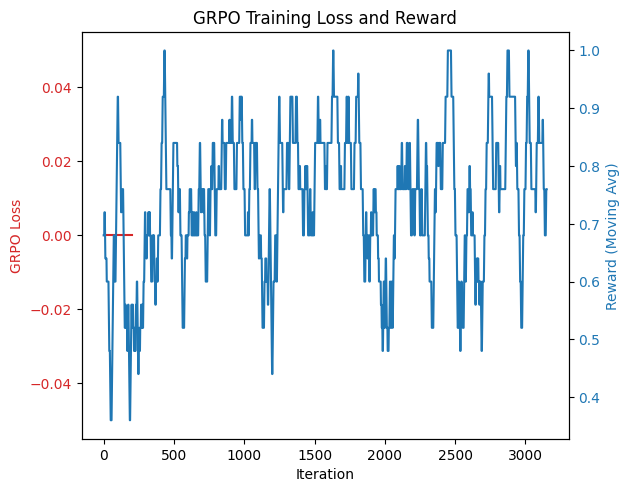

In [12]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('GRPO Loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Reward (Moving Avg)', color=color)
ax2.plot(moving_average(rewards, n=50), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("GRPO Training Loss and Reward")
plt.show();

### Evaluate

The training and validation loss are only part of the story. For HellaSwag, we ultimately care about how good the model is at answering questions. To asses this, let's generate the actual `ending1`, `ending2`, `ending3`, or `ending4` responses with the fine-tuned model and measure the accuracy.

First, let's split the last word off of each output in the test set to create a prompt without the answer.

In [17]:
test_set_eval = [(t["instruction"], *t["output"].rsplit(" ", maxsplit=1)) for t in test_set]

In [18]:
test_set[1]

{'instruction': 'Please choose the correct ending to complete the given sentence: Clean and jerk: A lady walks to a barbell. She bends down and grabs the pole. the lady\n\nEnding1: swings and lands in her arms. Ending2: pulls the barbell forward. Ending3: pulls a rope attached to the barbell. Ending4: stands and lifts the weight over her head.\n\nAnswer format: ending1/ending2/ending3/ending4',
 'input': '',
 'output': 'the correct answer is ending4',
 'answer': 'ending4'}

Next, we'll generate the response for each example in the test set and compare it to the ground-truth answer to measure the accuracy.

In [19]:
def evaluate(model, tokenizer, num_test):
    num_correct = 0
    for prompt, completion, answer in tqdm.tqdm(test_set_eval[:num_test]):
        messages = [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": completion}
        ]
        # Use greedy decoding for evaluation
        response = generate(model, tokenizer, prompt=messages, max_tokens=4, temp=0.0)
        num_correct += (answer in response)
    return num_correct / num_test

In [33]:
def evaluate(model, tokenizer, num_test):
    num_correct = 0
    for prompt, completion, answer in tqdm.tqdm(test_set_eval[:num_test]):
        # Convert chat-like messages into a plain text prompt
        prompt_text = f"User: {prompt}\nAssistant:"

        # Use greedy decoding for deterministic output
        response = generate(
            model,
            tokenizer,
            prompt=prompt_text,
            max_tokens=10
        )

        # Normalize and compare
        response_text = response.strip().lower()
        if answer.lower() in response_text:
            num_correct += 1

    return num_correct / num_test


In [34]:
# Put model in eval mode for evaluation
model.eval()

# Increase this number to use more test examples
num_test = 100
test_acc = evaluate(model, tokenizer, num_test)
print(f"Approximate test accuracy {test_acc:.3f}")

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]

Approximate test accuracy 0.790


### Fuse Adapters

Sometimes its convenient to fuse the adapters into the base model to create a single adapted model. MLX LM has a fuse script just for that.

To see more options for fusing the model, including how to upload to HuggingFace [check the documentation](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#fuse).

In [ ]:
!mlx_lm.fuse --model {model_path} --adapter-path {adapter_path} --save-path {"fused_model_GRPO"}

Loading pretrained model
Fetching 9 files: 100%|███████████████████████| 9/9 [00:00<00:00, 127100.12it/s]
Traceback (most recent call last):
  File "/Users/dariomelle/anaconda3/envs/gptoss20b-finetuning-mlx/bin/mlx_lm.fuse", line 7, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/dariomelle/anaconda3/envs/gptoss20b-finetuning-mlx/lib/python3.12/site-packages/mlx_lm/fuse.py", line 99, in main
    raise ValueError(
ValueError: Model type phi3 not supported for GGUF conversion.


Once the adapters are fused, we can rerun the evaluation using the fused model to make sure it worked. By default the fused model will be saved to `fused_model`.

In [ ]:
model_fused, tokenizer_fused = load("fused_model_GRPO")

In [35]:

test_acc_fused = evaluate(model_fused, tokenizer_fused, num_test)
print(f"Approximate fused model test accuracy {test_acc_fused:.3f}")


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]

Approximate fused model test accuracy 0.790


### Troubleshooting

#### Results

To figure out why your GRPO fine-tuning is not working well, it's critical to plot both the loss and the average reward. 

**Underfitting**: The average reward is not increasing significantly and remains low. The loss may be stagnant or decreasing very slowly. This means the model isn't learning the desired behavior. You have a few options to improve the results:

- **Increase the learning rate**: A higher learning rate might be needed to escape local minima.
- **Increase `group_size` (G)**: A larger group provides a more stable estimate of the advantage, which can improve the quality of the gradients.
- **Tune the KL penalty `beta`**: If `beta` is too high, it will prevent the model from learning, acting as an overly strong regularizer. Try decreasing it.
- **Increase adapter capacity**: Use more `lora_layers` or a higher `rank`.
- **Check your reward function**: Ensure the reward accurately reflects the desired outcome. For simple tasks like this, it's straightforward, but for complex tasks, this is often a source of error.

**Overfitting/Instability**: The reward increases initially but then crashes, or the loss fluctuates wildly. This means the policy updates are too large and are destabilizing the model.

- **Decrease the learning rate**: This is the most common fix for instability.
- **Tune the PPO clip `epsilon`**: A smaller `epsilon` (e.g., 0.1) will make the updates more conservative.
- **Increase the KL penalty `beta`**: A larger `beta` will pull the policy back towards the original reference model, preventing it from straying too far into unstable regions.
- **Update `model_old` less frequently**: Increasing `update_every` can sometimes add stability.

#### Memory Use

RL fine-tuning can be more memory-intensive than SFT due to storing rollouts and multiple models. Here are some tips to reduce memory use:

- **Reduce `batch_size` or `group_size`**: These directly control how many sequences are held in memory for each iteration.
- **Quantization (QLoRA)**: This is highly effective. You can use a quantized base model from Hugging Face or create one with `mlx_lm.convert`.
- **Gradient Checkpointing**: This trades computation for memory. Add `grad_checkpoint=True` when calling the training loop and pass it down to the loss function if needed (though our custom loop doesn't have this argument, it could be added).
- **Reduce `lora_layers` or `rank`**: Fewer trainable parameters means a smaller memory footprint for gradients and optimizer states.

### Next Steps

- To learn more about MLX check-out the [GitHub repo](http://github.com/ml-explore/mlx) and [documentation](https://ml-explore.github.io/mlx/)
- For more on MLX LM check-out the [MLX LM documentation](https://github.com/ml-explore/mlx-examples/tree/main/llms#readme).
- Check out the other [MLX Examples](https://github.com/ml-explore/mlx-examples/tree/main). These are great as a learning resource or to use as a starting point for a new project.